Лемматизируем текст и делаем табличку, удобную для работа

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
from string import punctuation
import nltk
from itertools import chain
from pymorphy2 import MorphAnalyzer
import nltk
nltk.download('punkt')
def clean_up(pp: str):
    morph = MorphAnalyzer()
    sent = sent_tokenize(pp.lower())
    tok = list(map(lambda x: word_tokenize(x), sent))
    tok = list(chain(*tok))
    #tok = list(filter(lambda x: x not in punctuation, tok))
    #tok = list(filter(lambda x: x not in '«»–', tok))
    lem = list(map(lambda x: morph.parse(x)[0].normal_form, tok))

    return lem

In [ ]:
with open('/Users/karpovapolina/Downloads/train_reviews.txt', 'r') as f:
    lines = f.readlines()

data = [tuple(map(str.strip, line.split('\t', 1))) for line in lines]

reviews_df = pd.DataFrame(data, columns=['ID', 'Review'])

reviews_df['ID'] = reviews_df['ID'].astype(int)

In [ ]:
reviews = reviews_df['Review'].to_list()

lemmatized_reviews = []

for i in reviews:
  lemmatized_review = clean_up(i)
  lemmatized_reviews.append(' '.join(lemmatized_review))

In [ ]:
reviews_df['Lemmatized Review'] = lemmatized_reviews

In [ ]:
lemmatized_text = reviews_df['Lemmatized Review']

In [ ]:
with open('/content/train_cats.txt', 'r') as file:
    lines = file.readlines()

data = [tuple(line.strip().split('\t')) for line in lines]

columns = ['ID', 'Category', 'Sentiment']
category_df = pd.DataFrame(data, columns=columns)
category_df['ID'] = pd.to_numeric(category_df['ID'])



In [ ]:
category_df

,ID,Category,Sentiment
0,3976,Food,positive
1,3976,Interior,positive
2,3976,Price,absence
3,3976,Whole,positive
4,3976,Service,positive
...,...,...,...
1415,16630,Food,positive
1416,16630,Interior,positive
1417,16630,Price,absence
1418,16630,Whole,positive


In [ ]:
df_pivoted = category_df.pivot(index='ID', columns='Category', values='Sentiment').reset_index()

In [ ]:
df_pivoted

Category,ID,Food,Interior,Price,Service,Whole
0,280,positive,both,absence,positive,positive
1,343,positive,positive,absence,both,positive
2,719,both,both,absence,positive,positive
3,785,both,positive,negative,positive,both
4,797,neutral,absence,absence,negative,both
...,...,...,...,...,...,...
279,37975,positive,positive,positive,positive,positive
280,38077,positive,both,absence,positive,positive
281,38299,positive,positive,absence,positive,positive
282,38772,positive,positive,absence,positive,positive


In [ ]:
sentiment_mapping = {'positive': 0, 'negative': 1, 'both': 2, 'neutral': 3, 'absence': 4}

df_pivoted['Food'] = df_pivoted['Food'].replace(sentiment_mapping)
df_pivoted['Interior'] = df_pivoted['Interior'].replace(sentiment_mapping)
df_pivoted['Price'] = df_pivoted['Price'].replace(sentiment_mapping)
df_pivoted['Service'] = df_pivoted['Service'].replace(sentiment_mapping)
df_pivoted['Whole'] = df_pivoted['Whole'].replace(sentiment_mapping)

Анализируем данные.

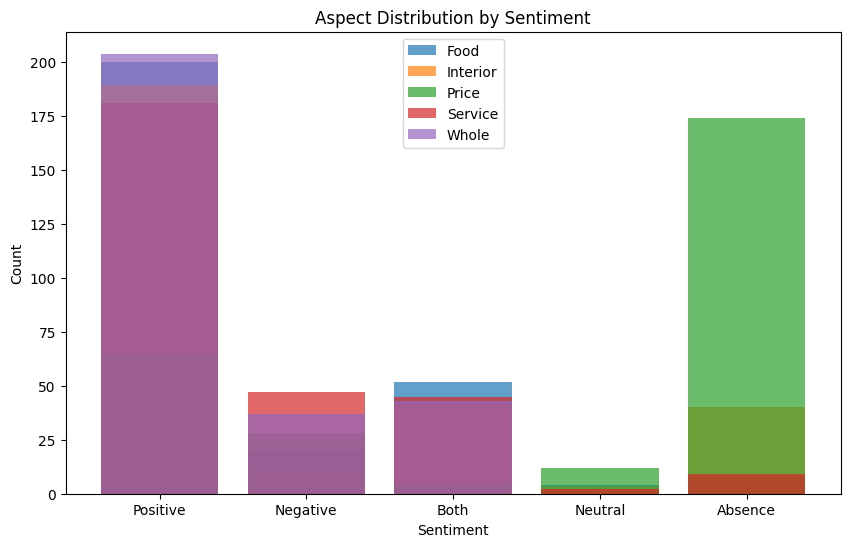

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
selected_columns = ['Food', 'Interior', 'Price', 'Whole', 'Service']
reverse_sentiment_mapping = {0: 'Positive', 1: 'Negative', 2: 'Both', 3: 'Neutral', 4: 'Absence'}


for aspect in df_pivoted.columns[1:]:
    sentiment_counts = df_pivoted.groupby(aspect).size()
    ax.bar(sentiment_counts.index, sentiment_counts, label=aspect, alpha=0.7)

ax.set_xticks(list(reverse_sentiment_mapping.keys()))
ax.set_xticklabels(reverse_sentiment_mapping.values())
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_title('Aspect Distribution by Sentiment')
ax.legend()

plt.show()

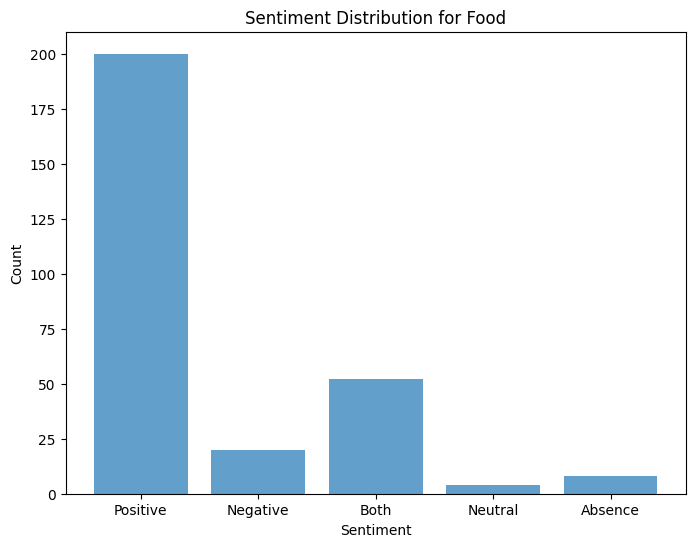

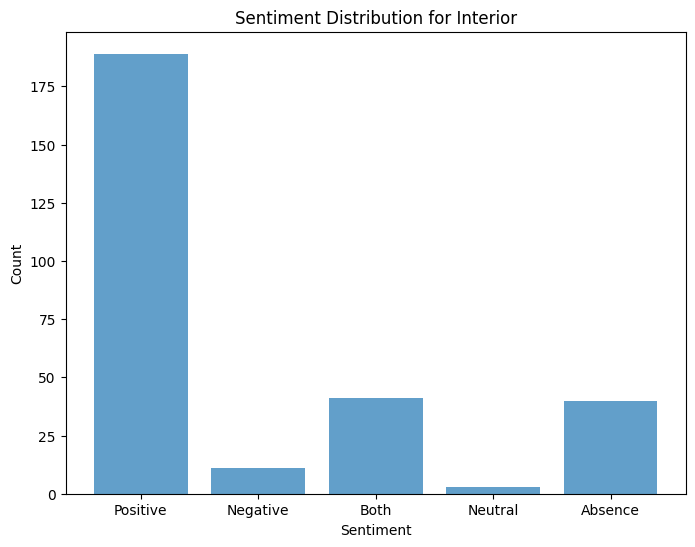

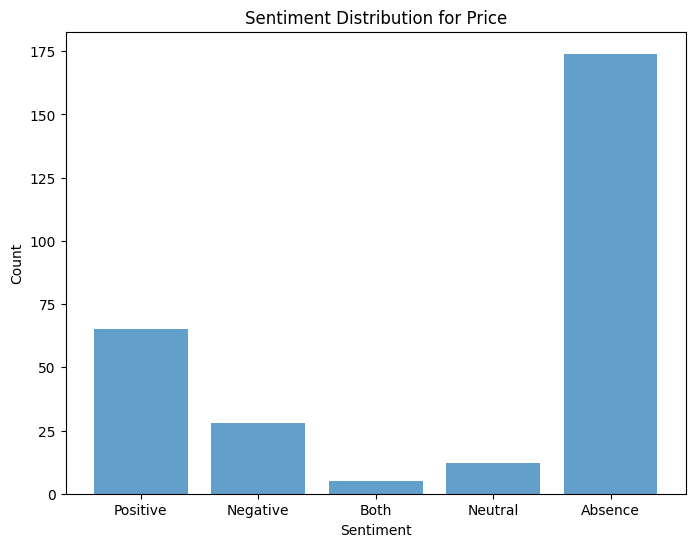

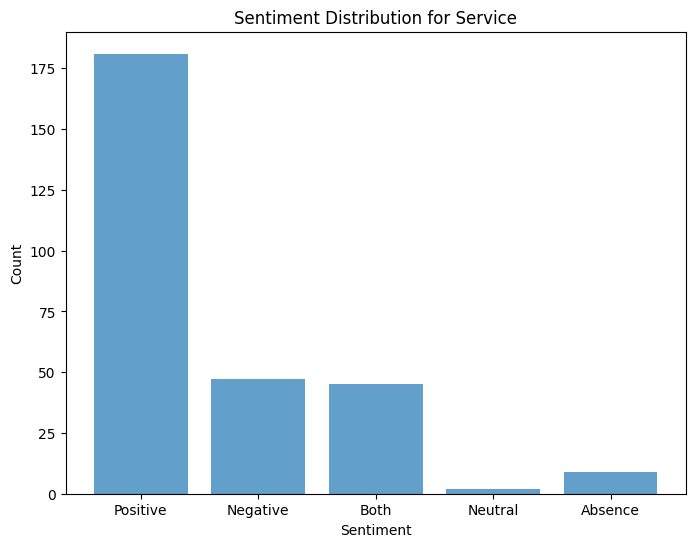

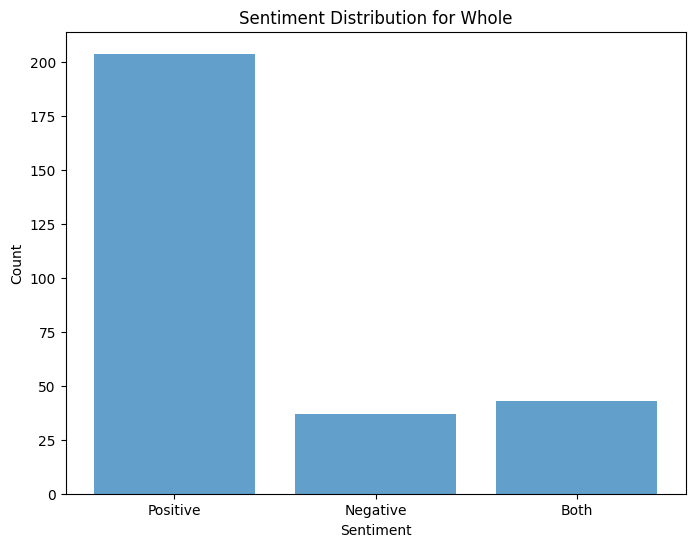

In [ ]:
for aspect in df_pivoted.columns[1:]:
    aspect_counts = df_pivoted.groupby(aspect).size()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(aspect_counts.index.map(reverse_sentiment_mapping), aspect_counts, alpha=0.7)

    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Count')
    ax.set_title(f'Sentiment Distribution for {aspect}')

    plt.show()

Выводы: очень мало данных, большая разница в дистрибуции по сентиментам и неравномерные классы.

In [ ]:
merged_df = pd.merge(df_pivoted , reviews_df_chosen, on='ID', how='outer')

Загружаем модель. Я умерла, пытаясь делать multi class multi label classification и файнтюйнить на это берт. Поэтому тут просто пять бертов на пять аспектов. Прогоняла код пять раз, меняя в preprocess аспект.

In [ ]:
from transformers import AutoModelForSequenceClassification
rubert_model = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased",problem_type="multi_label_classification", num_labels=5, id2label=reverse_sentiment_mapping, label2id=sentiment_mapping)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np

def number_to_array(num):
    if not 0 <= num <= 4:
        raise ValueError("Input number must be between 0 and 4 inclusive.")

    return np.eye(5)[num]


In [ ]:
import torch
from transformers import AutoTokenizer
import numpy as np
rubert_tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
def preprocess(row):

    labels = number_to_array(merged_df['Whole'][row.name])
    tokens = rubert_tokenizer.encode_plus(row['Lemmatized Review'],
                                   add_special_tokens=True,
                                   max_length=128,
                                   padding='max_length',
                                   return_tensors='pt',
                                   truncation=True)

    return {
        'input_ids': tokens['input_ids'].tolist()[0],
        'attention_mask': tokens['attention_mask'].tolist()[0],
        'labels': labels.astype(np.float32),
        'text': row['Review'],
    }

merged_df['preprocessing'] = merged_df.apply(preprocess, axis=1)


In [ ]:
 device = torch.device('cuda:0')

In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(merged_df, test_size=0.2, shuffle=True)

In [ ]:

train_data = {
    'input_ids': train_dataset['preprocessing'].apply(lambda x: x['input_ids']).tolist(),
    'attention_mask': train_dataset['preprocessing'].apply(lambda x: x['attention_mask']).tolist(),
    'labels': train_dataset['preprocessing'].apply(lambda x: x['labels']).tolist(),
    'text': train_dataset['preprocessing'].apply(lambda x: x['text']).tolist(),
    }

In [ ]:
test_data = {
    'input_ids': test_dataset['preprocessing'].apply(lambda x: x['input_ids']).tolist(),
    'attention_mask': test_dataset['preprocessing'].apply(lambda x: x['attention_mask']).tolist(),
    'labels': test_dataset['preprocessing'].apply(lambda x: x['labels']).tolist(),
    'text': test_dataset['preprocessing'].apply(lambda x: x['text']).tolist(),
    }

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset
train_data = Dataset.from_dict(train_data)

In [ ]:
test_data = Dataset.from_dict(test_data)

In [ ]:
from transformers import DataCollatorWithPadding
rubert_data_collator = DataCollatorWithPadding(tokenizer=rubert_tokenizer)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import numpy as np
from datasets import load_metric

def new_compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    f1_metric = load_metric("f1")

    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)

    accuracy = load_accuracy.compute(predictions=predictions.flatten().astype(int), references=labels.flatten().astype(int))
    f1 = f1_metric.compute(predictions=predictions.flatten().astype(int), references=labels.flatten().astype(int), average="macro")
    return {"accuracy": accuracy, "f1": f1}


In [ ]:
from torch.nn import BCEWithLogitsLoss
from transformers import TrainingArguments, Trainer

repo_name = "whole-rubert-sentiment-model"

rubert_training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

rubert_trainer = Trainer(
    model=rubert_model,
    args=rubert_training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=rubert_tokenizer,
    data_collator=rubert_data_collator,
    compute_metrics=new_compute_metrics,

)

In [ ]:
rubert_trainer.train()

Step,Training Loss


TrainOutput(global_step=30, training_loss=0.23675629297892253, metrics={'train_runtime': 49.2246, 'train_samples_per_second': 9.223, 'train_steps_per_second': 0.609, 'total_flos': 29863909169664.0, 'train_loss': 0.23675629297892253, 'epoch': 2.0})

In [ ]:
rubert_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

{'eval_loss': 0.23736000061035156,
 'eval_accuracy': {'accuracy': 0.8982456140350877},
 'eval_f1': {'f1': 0.8307219662058372},
 'eval_runtime': 1.2958,
 'eval_samples_per_second': 43.987,
 'eval_steps_per_second': 3.087,
 'epoch': 2.0}

In [ ]:
rubert_trainer.push_to_hub()

events.out.tfevents.1703843421.454b486c958a.1457.7:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

events.out.tfevents.1703843719.454b486c958a.1457.8:   0%|          | 0.00/354 [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

'https://huggingface.co/numblilbug/whole-rubert-sentiment-model/tree/main/'